In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch.nn as nn
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import seaborn as sns

/opt/miniconda3/envs/cb/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'seaborn'

In [3]:
model_name = "InstaDeepAI/nucleotide-transformer-v2-100m-multi-species"

tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

## Load data

In [4]:
ds_arg = pd.read_csv('/content/drive/MyDrive/PUBH 8885 CB/short_reads_with_type.csv')
ds_arg.head()

,id,type,Sequence
0,B9J113,beta_lactam,GTGAAACATAAAAATCAGGCGACGCATAAAGAGTTCTCTCAACTTG...
1,B9J113,beta_lactam,AAACAATCGCTTATCGACCTAACGAAAGGTTTGCCTTTGCATCAAC...
2,B9J113,beta_lactam,AGATGAAGTTATTACTTATACGAAAGAAGACTTAGTGGATTATTCA...
3,B9J113,beta_lactam,GCTGCTGTTCGTTACAGTGATAATACTGCAGGGAACATTTTATTTC...
4,B9J113,beta_lactam,GGGTTACTATGTCTGATCGCTTTGAAACAGAGTTAAACGAAGCTAT...


In [5]:
# Create label encoder for drug resistance types
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(ds_arg['type'])
sequences = ds_arg['Sequence'].values
dataset = pd.DataFrame({
    'sequence': sequences,
    'label': labels
})
print(dataset)

                                                sequence  label
0      GTGAAACATAAAAATCAGGCGACGCATAAAGAGTTCTCTCAACTTG...      2
1      AAACAATCGCTTATCGACCTAACGAAAGGTTTGCCTTTGCATCAAC...      2
2      AGATGAAGTTATTACTTATACGAAAGAAGACTTAGTGGATTATTCA...      2
3      GCTGCTGTTCGTTACAGTGATAATACTGCAGGGAACATTTTATTTC...      2
4      GGGTTACTATGTCTGATCGCTTTGAAACAGAGTTAAACGAAGCTAT...      2
...                                                  ...    ...
96140  GTGGCTGAACTCCATTACTGTCAGGGTGAAAGAAGGATTTGACAGC...      7
96141  GATTTCTTTACCTGGAACATGGACGGCGTCTTGAAAACCGTTGAAA...      7
96142  TGGTGGGCGGTATTGGTGTAATGAATATTATGCTGGTGTCAGTGAC...      7
96143  TGTTTTGCAACAGTTCCTGATCGAAGCCGTGCTGGTTTGCCTGGTC...      7
96144  TTCTTACCCGGCTGGGAGATTGGTTTTTCACCGTTGGCGCTGCTGC...      7

[96145 rows x 2 columns]


In [6]:
# Create Train Test split
train_sequences, test_sequences, train_labels, test_labels = train_test_split(dataset['sequence'], dataset['label'], test_size=0.1, random_state=42)

In [11]:
ds_train = Dataset.from_dict({"sequence": train_sequences,'labels':train_labels})
ds_test = Dataset.from_dict({"sequence": test_sequences,'labels':test_labels})

In [12]:
# Tokenize the dataset
def tokenize_function(data):
    return tokenizer(
        data['sequence'],
        padding='max_length',
        max_length=100,
        truncation=True,       # Truncate if longer than max_length
        return_tensors='pt'    # Return pytorch tensors
    )

In [13]:
tokenized_datasets_train = ds_train.map(
    tokenize_function,
    batched=True,
    remove_columns=['sequence']
)

Map:   0%|          | 0/86530 [00:00<?, ? examples/s]

In [14]:
tokenized_datasets_test = ds_test.map(
    tokenize_function,
    batched=True,
    remove_columns=['sequence']
)

Map:   0%|          | 0/9615 [00:00<?, ? examples/s]

## Layer Ablation

In [15]:
pretrained_model = AutoModelForSequenceClassification.from_pretrained(model_name, trust_remote_code=True)

config.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

esm_config.py:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-100m-multi-species:
- esm_config.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_esm.py:   0%|          | 0.00/58.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-100m-multi-species:
- modeling_esm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/392M [00:00<?, ?B/s]

Some weights of the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-100m-multi-species were not used when initializing EsmForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-100m-multi-species and are newly initialized: ['classifier.dense.bias', 

In [16]:
pretrained_model.eval()
pretrained_model.requires_grad_(False)

EsmForSequenceClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(4107, 512, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(2050, 512, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-21): 22 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((512,), eps=1e

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
def extract_embeddings(model, tokenizer, sequences, batch_size=8, device='cuda'):
    """Extract CLS token embeddings for input sequences."""
    model = model.to(device)
    embeddings = []

    for i in range(0, len(sequences), batch_size):
        batch = sequences[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
        cls_embeddings = outputs['hidden_states'][-1][:, 0, :].cpu().numpy()
        embeddings.append(cls_embeddings)

    # Combine all batches
    return np.vstack(embeddings)

In [19]:
train_sequences = list(train_sequences)


In [21]:
test_sequences = list(test_sequences)

In [22]:
train_embeddings = extract_embeddings(pretrained_model, tokenizer, train_sequences, batch_size=16)

In [23]:
test_embeddings = extract_embeddings(pretrained_model, tokenizer, test_sequences, batch_size=16)

In [24]:
# Train logistic regression model
logreg = LogisticRegression(max_iter=1000, solver = 'lbfgs', random_state=42)
logreg.fit(train_embeddings, train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

In [25]:
# Evaluate on test data
test_predictions = logreg.predict(test_embeddings)

In [26]:
# Calculate evaluation metrics
accuracy = accuracy_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions, average="weighted")
precision = precision_score(test_labels, test_predictions, average="weighted")
recall = recall_score(test_labels, test_predictions, average="weighted")

print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Logistic Regression Performance:
Accuracy: 0.5305
F1 Score: 0.5089
Precision: 0.5288
Recall: 0.5305


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Visualizations

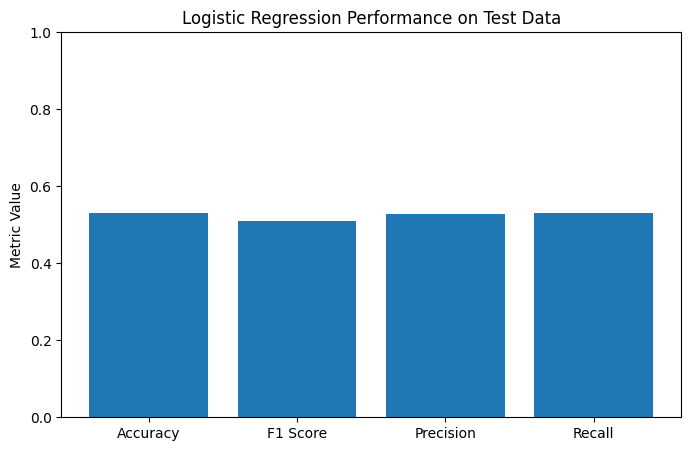

In [27]:
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
values = [accuracy, f1, precision, recall]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values)
plt.ylim(0, 1)  # Performance metrics range from 0 to 1
plt.title('Logistic Regression Performance on Test Data')
plt.ylabel('Metric Value')
plt.show()

In [28]:
print("Number of classes in test_labels:", len(np.unique(test_labels)))
print("Number of classes in label_encoder:", len(label_encoder.classes_))

Number of classes in test_labels: 13
Number of classes in label_encoder: 15


In [29]:
unique_classes = np.unique(test_labels)  # Get unique classes from the test set
class_names = label_encoder.inverse_transform(unique_classes)  # Get corresponding class names

In [30]:
class_names

array(['aminoglycoside', 'bacitracin', 'beta_lactam', 'chloramphenicol',
       'fosfomycin', 'glycopeptide',
       'macrolide-lincosamide-streptogramin', 'multidrug', 'mupirocin',
       'polymyxin', 'quinolone', 'tetracycline', 'trimethoprim'],
      dtype=object)

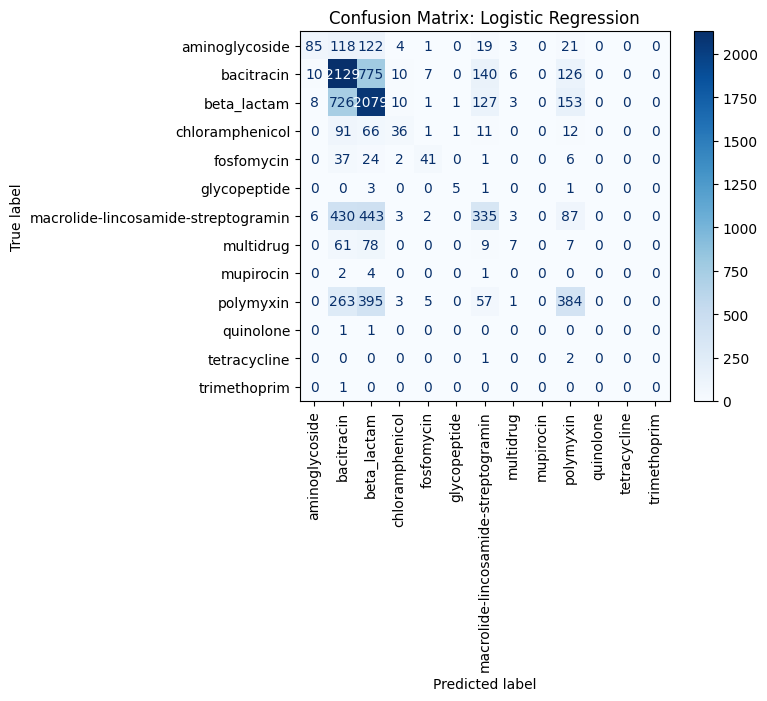

In [35]:
cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix: Logistic Regression")
plt.show()

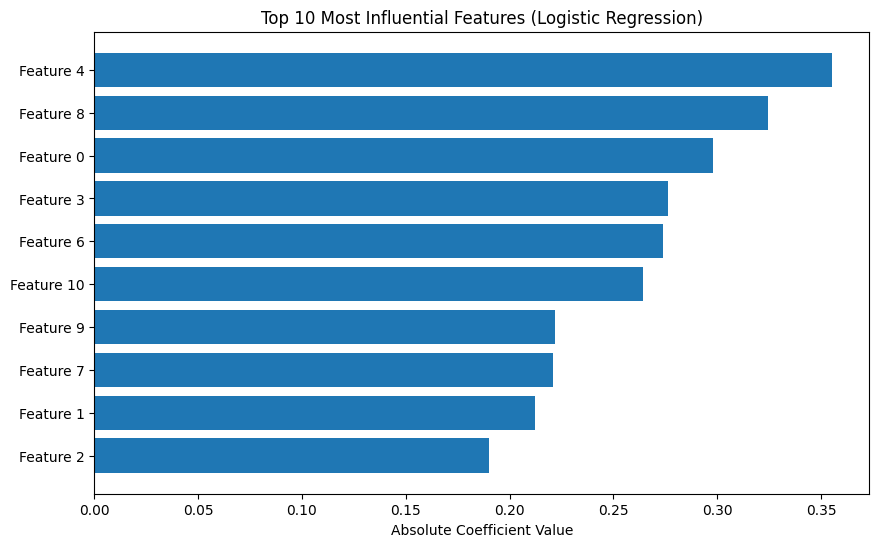

In [36]:
feature_importance = np.mean(np.abs(logreg.coef_), axis=1)
top_indices = feature_importance.argsort()[-10:][::-1]  # Top 10 features

plt.figure(figsize=(10, 6))
plt.barh(range(10), feature_importance[top_indices], align='center')
plt.yticks(range(10), [f"Feature {i}" for i in top_indices])
plt.gca().invert_yaxis()
plt.title("Top 10 Most Influential Features (Logistic Regression)")
plt.xlabel("Absolute Coefficient Value")
plt.show()

# layer_importance =
# plt.plot(range(len(layer_importance)), layer_importance)
# plt.title("Average Feature Importance Across Layers")
# plt.xlabel("Layer")
# plt.ylabel("Average Absolute Coefficient")
# plt.show()


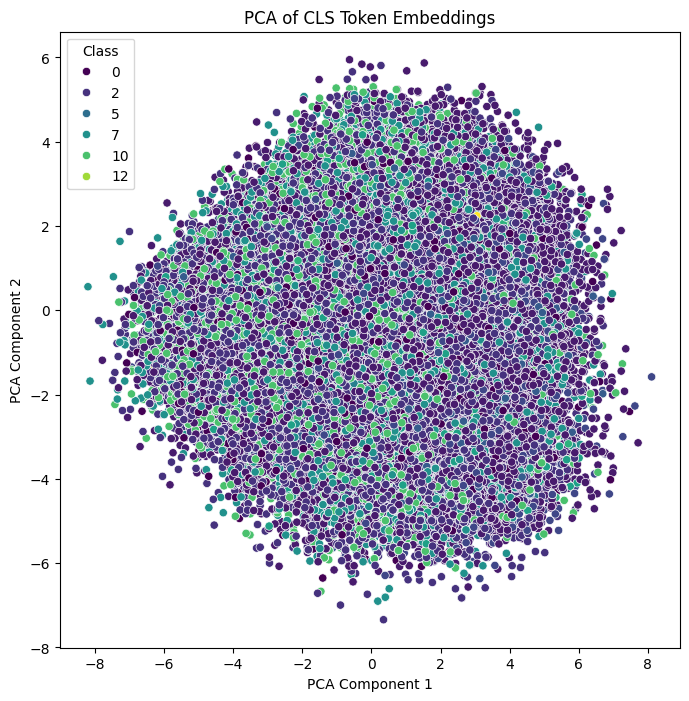

In [37]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(train_embeddings)

# Visualize the embeddings with labels
plt.figure(figsize=(8, 8))
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=train_labels, palette="viridis")
plt.title("PCA of CLS Token Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Class")
plt.show()

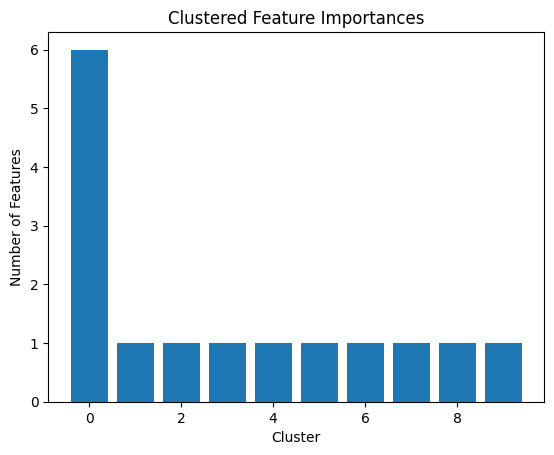

In [38]:
from sklearn.cluster import KMeans

# Cluster feature importance scores
n_clusters = 10  # Adjust based on your dataset
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(np.abs(logreg.coef_))

# Plot cluster importance
plt.bar(range(n_clusters), np.bincount(clusters))
plt.title("Clustered Feature Importances")
plt.xlabel("Cluster")
plt.ylabel("Number of Features")
plt.show()

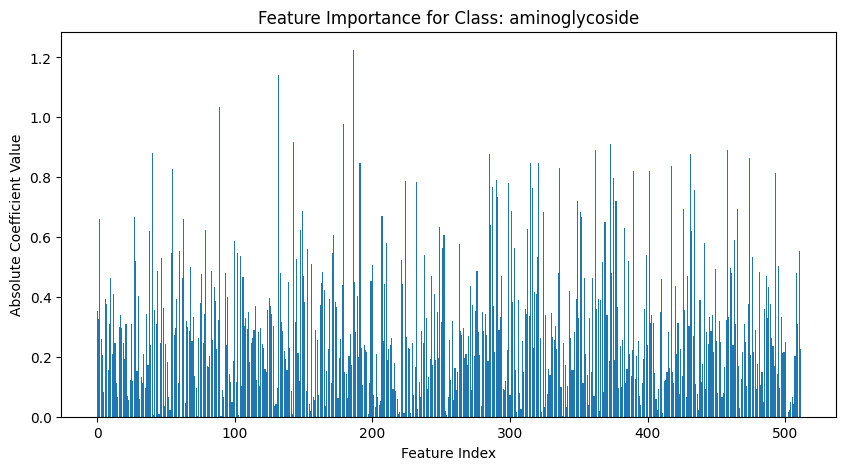

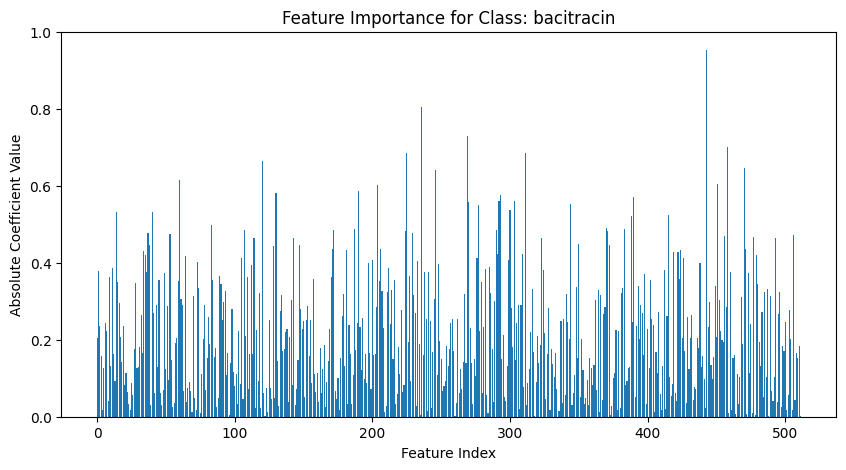

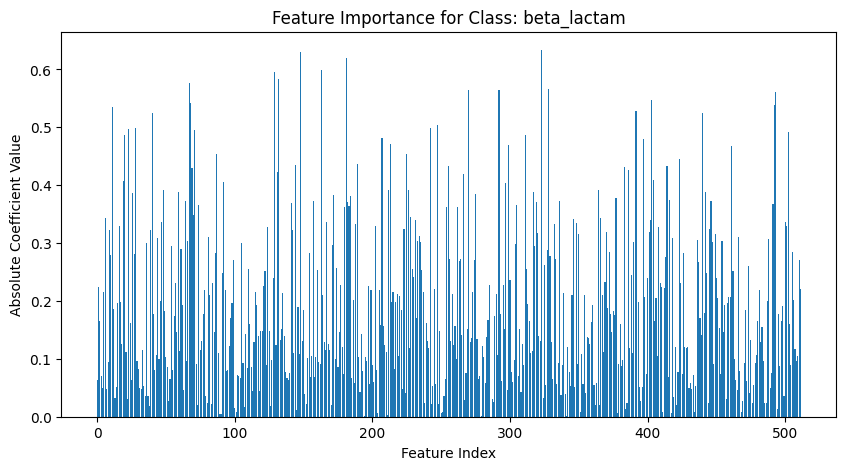

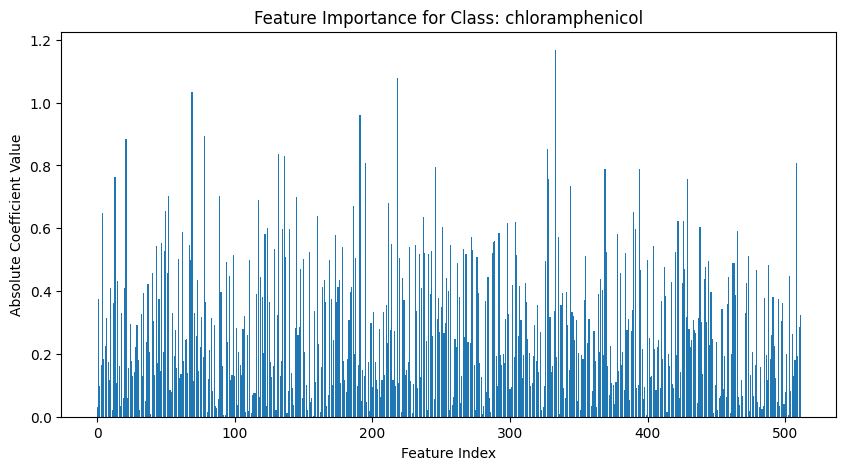

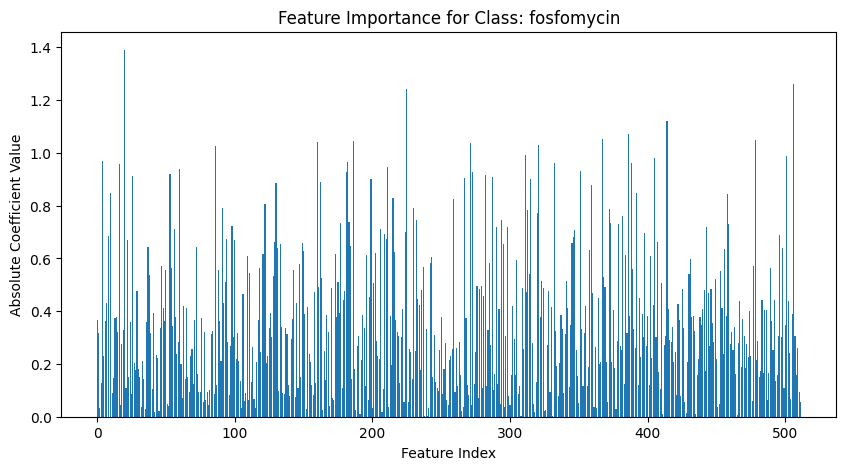

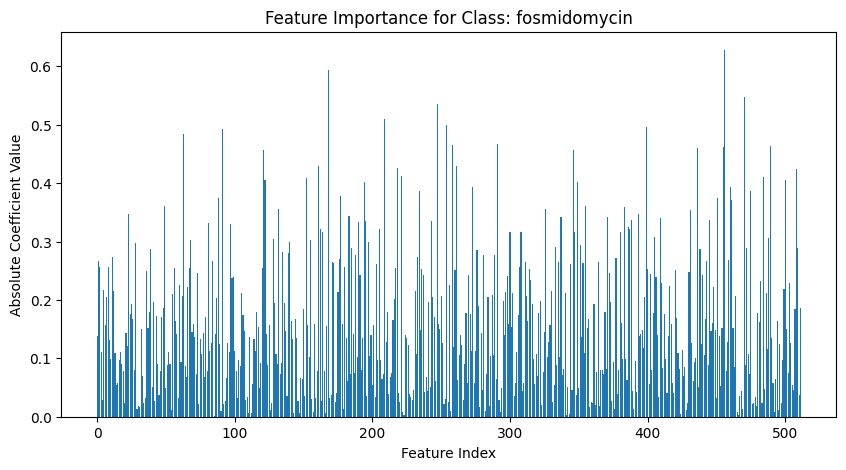

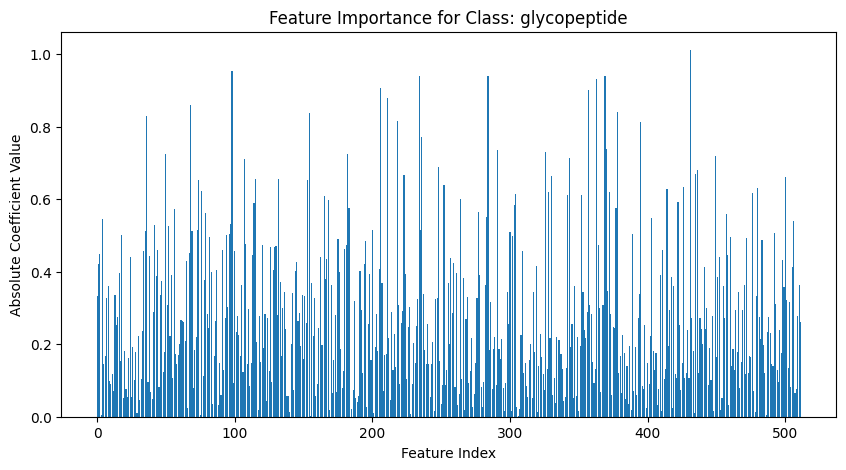

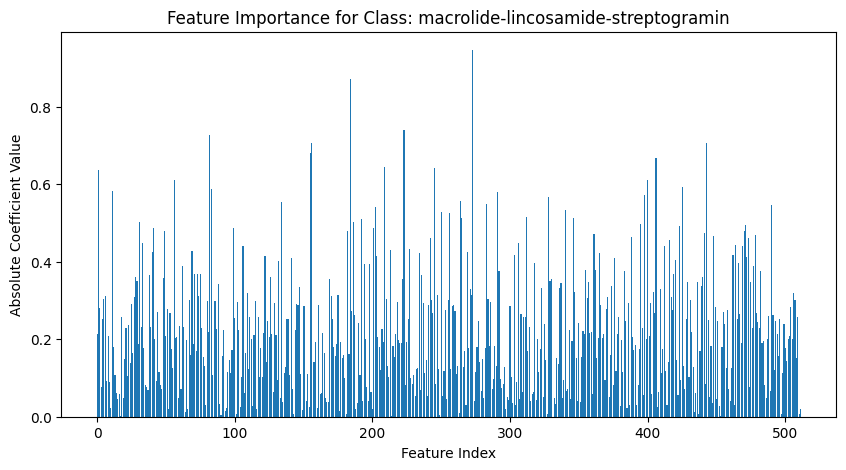

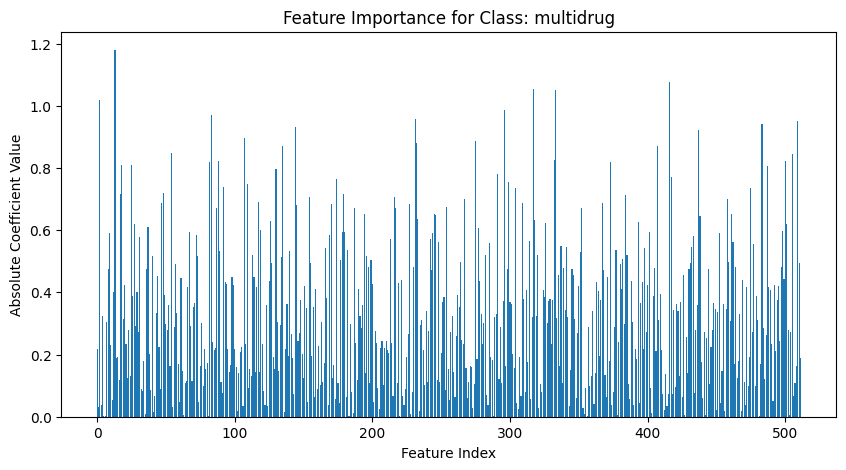

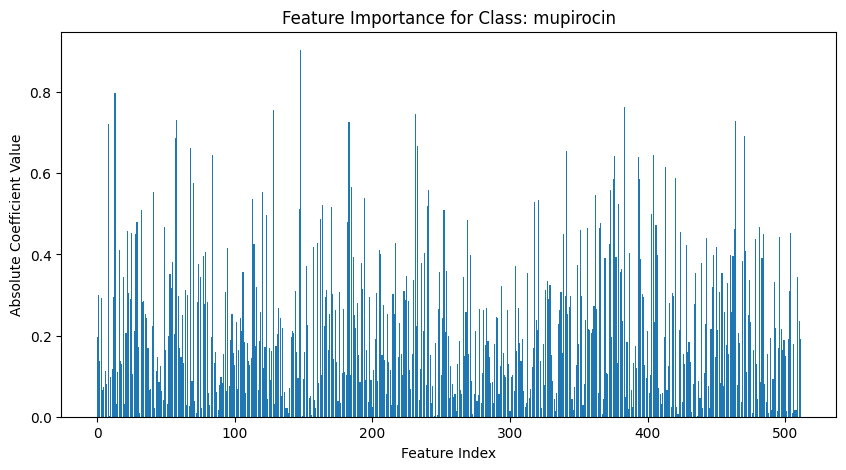

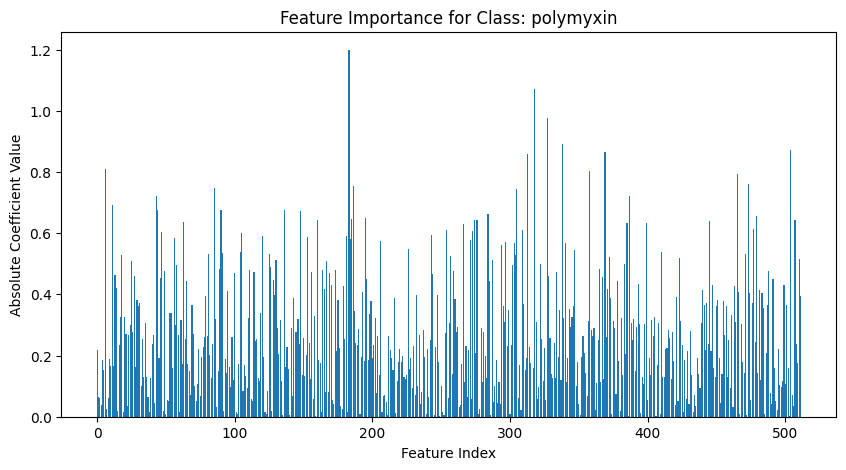

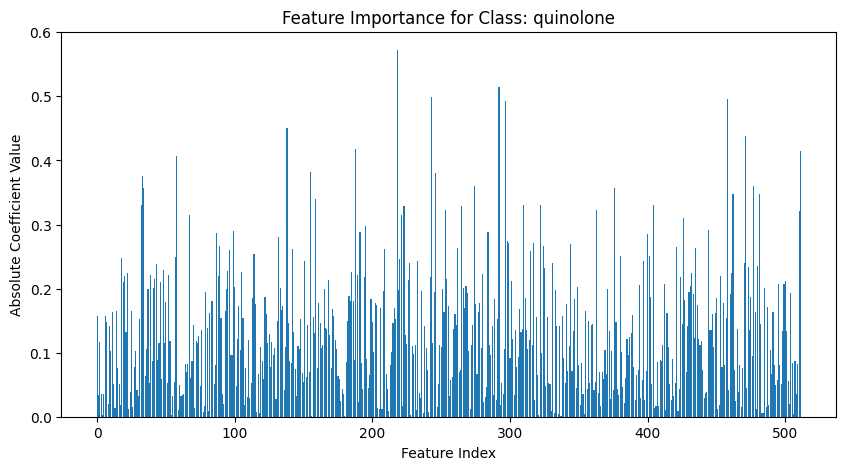

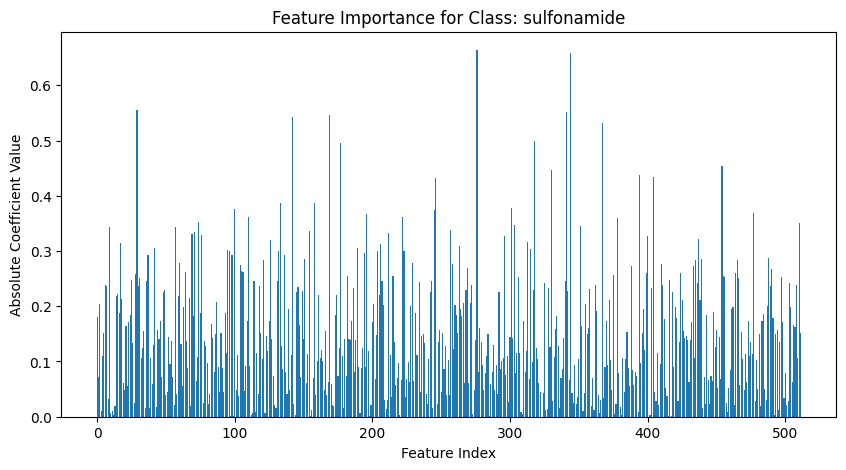

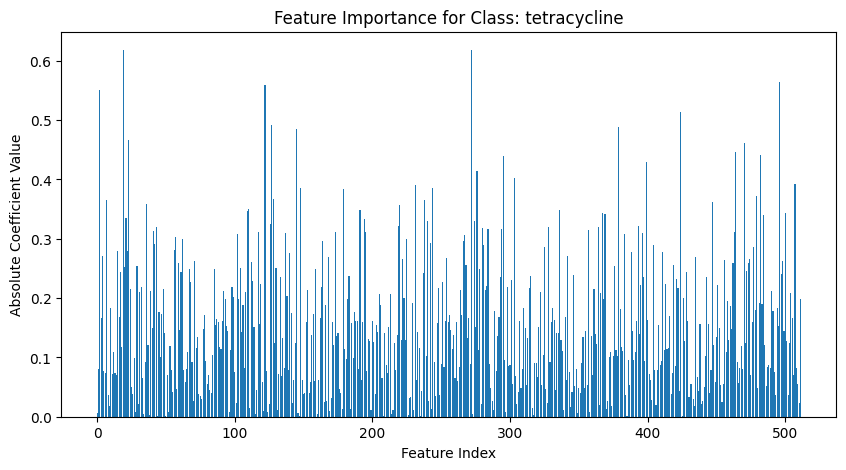

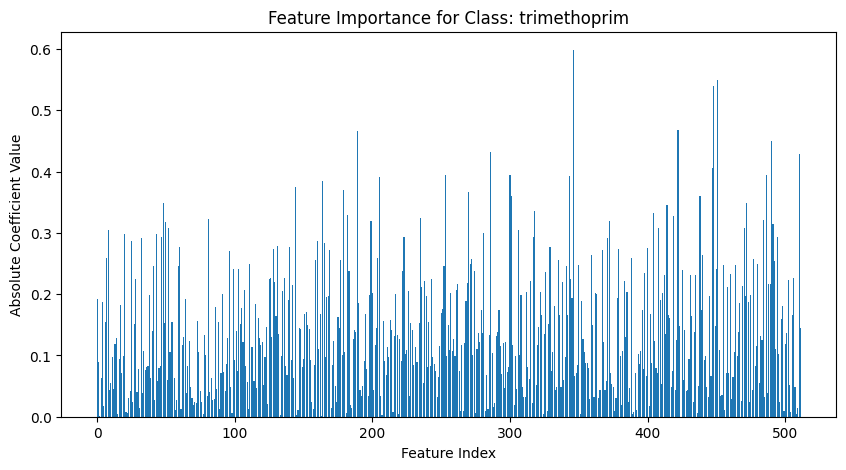

In [39]:
for i, class_name in enumerate(label_encoder.classes_):
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(logreg.coef_[i])), np.abs(logreg.coef_[i]))
    plt.title(f"Feature Importance for Class: {class_name}")
    plt.xlabel("Feature Index")
    plt.ylabel("Absolute Coefficient Value")
    plt.show()

In [2]:
import matplotlib as plt

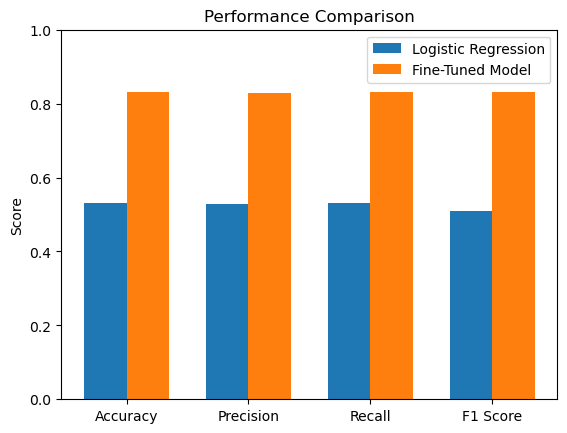

In [5]:
# Performance metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
logreg_scores = [0.5305, 0.5288, 0.5305, 0.5089]
finetuned_scores = [0.831979, 0.829460, 0.831979, 0.830177]


# Bar plot
x = range(len(metrics))
width = 0.35

plt.bar(x, logreg_scores, width, label='Logistic Regression')
plt.bar([p + width for p in x], finetuned_scores, width, label='Fine-Tuned Model')

plt.xticks([p + width / 2 for p in x], metrics)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Performance Comparison')
plt.legend()
plt.show()